In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('../data/names/*.txt'))

['../data/names/Czech.txt', '../data/names/German.txt', '../data/names/Arabic.txt', '../data/names/Japanese.txt', '../data/names/Chinese.txt', '../data/names/Vietnamese.txt', '../data/names/Russian.txt', '../data/names/French.txt', '../data/names/Irish.txt', '../data/names/English.txt', '../data/names/Spanish.txt', '../data/names/Greek.txt', '../data/names/Italian.txt', '../data/names/Portuguese.txt', '../data/names/Scottish.txt', '../data/names/Dutch.txt', '../data/names/Korean.txt', '../data/names/Polish.txt']


In [6]:
import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii("Ślusàrski"))  

Slusarski


In [7]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


for filename in findFiles("../data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)
print(category_lines["Italian"][:5])

18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [15]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)


def letterToTensor(letter):
    tensor  = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor 



def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    
    return tensor


print(letterToTensor('J'))
print(lineToTensor("Jone").size())
# print(lineToTensor("Jone"))
print()

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([4, 1, 56])



In [13]:
# create the network
import torch.nn as nn 

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    

    def forward(self, input, hidden):
        print("input-size = ", input.size())
        print("hidden-size = ", hidden.size())
        combined = torch.cat((input, hidden), 1)
        print("combined-size = ", combined.size())
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [14]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

print(input.size())
print(output)

input-size =  torch.Size([1, 56])
hidden-size =  torch.Size([1, 128])
combined-size =  torch.Size([1, 184])
torch.Size([1, 56])
tensor([[-2.9213, -2.9276, -2.9547, -2.7530, -2.8368, -2.9279, -2.9089, -3.0202,
         -2.8787, -2.9233, -2.7947, -2.8774, -2.7738, -2.8774, -2.9447, -2.8687,
         -2.9331, -2.9447]], grad_fn=<LogSoftmaxBackward>)


In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8856, -2.9595, -2.8282, -2.8593, -2.9705, -2.8295, -2.8965, -2.9460,
         -2.8614, -2.7490, -2.8770, -2.9873, -2.9554, -2.7899, -2.9130, -2.9781,
         -2.8917, -2.8869]], grad_fn=<LogSoftmaxBackward>)


In [8]:
# prepare for training 
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 9)


In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Portuguese / line = Fernandes
category = Korean / line = Choe
category = Japanese / line = Chikanatsu
category = Irish / line = Reagan
category = Russian / line = Isadjanov
category = German / line = Holtzer
category = Japanese / line = Ushiba
category = Russian / line = Abdulhabirov
category = Dutch / line = Klerken
category = Vietnamese / line = Thach


In [10]:
# training 
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


In [11]:
import math 
import time

n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

start = time.time()

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(category_tensor.size(), line_tensor.size())
    output, loss = train(category_tensor, line_tensor)
    print(output.size(), loss)
    current_loss += loss

    if iter * print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

[1, 18]) 3.0876975059509277
torch.Size([1]) torch.Size([7, 1, 56])
torch.Size([1, 18]) 3.737551689147949
torch.Size([1]) torch.Size([5, 1, 56])
torch.Size([1, 18]) 0.797877848148346
torch.Size([1]) torch.Size([8, 1, 56])
torch.Size([1, 18]) 0.5209336876869202
torch.Size([1]) torch.Size([4, 1, 56])
torch.Size([1, 18]) 0.8487834334373474
torch.Size([1]) torch.Size([6, 1, 56])
torch.Size([1, 18]) 5.24036979675293
torch.Size([1]) torch.Size([5, 1, 56])
torch.Size([1, 18]) 2.802518367767334
torch.Size([1]) torch.Size([8, 1, 56])
torch.Size([1, 18]) 1.6789233684539795
torch.Size([1]) torch.Size([5, 1, 56])
torch.Size([1, 18]) 2.890965461730957
torch.Size([1]) torch.Size([8, 1, 56])
torch.Size([1, 18]) 0.06455075740814209
torch.Size([1]) torch.Size([6, 1, 56])
torch.Size([1, 18]) 1.306164264678955
torch.Size([1]) torch.Size([8, 1, 56])
torch.Size([1, 18]) 1.4620048999786377
torch.Size([1]) torch.Size([8, 1, 56])
torch.Size([1, 18]) 3.220737934112549
torch.Size([1]) torch.Size([7, 1, 56])
torc

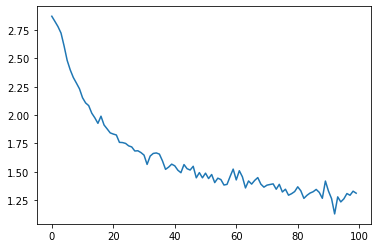

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-15-c4ffa58a0aa3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-15-c4ffa58a0aa3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


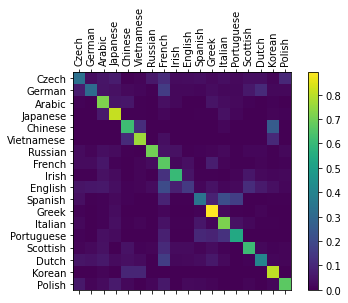

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output


for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()



# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))